In [92]:
import json
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
from datasets import load_dataset, Dataset
import warnings
warnings.filterwarnings("ignore")

In [537]:
models_dict = {
    'Base': {
        'short_name': 'base', 
        'full_name': 'ALMA-13B-SFT-HW', 
    },
    'Reference': {
        'short_name': 'ref',
    },
    'GPT-4': {
        'short_name': 'gpt4', 
    },
    'Rejected': {
        'short_name': 'rejected', 
    },
    'Chosen': {
        'short_name': 'chosen', 
    },
    'SFT-Multi-xCOMET-QE': {
        'short_name': 'sft_xcomet_multi',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-xCOMET-QE', 
    },
    'SFT-Multi-CometKiwi': {
        'short_name': 'sft_kiwi_multi',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-CometKiwi', 
    },
    'SFT-Multi-chrF': {
        'short_name': 'sft_chrf_multi',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-chrF',
    },
    'CPO-Multi-xCOMET-QE': {
        'short_name': 'cpo_xcomet_multi',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-xCOMET-QE',
    },
    'CPO-Multi-xCOMET-QE-Choose-Base': {
        'short_name': 'cpo_xcomet_multi_cb',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-xCOMET-QE-Choose-Base',
    },
    'CPO-Multi-CometKiwi': {
        'short_name': 'cpo_kiwi_multi',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-CometKiwi',
    },
    'CPO-Multi-chrF': {
        'short_name': 'cpo_chrf_multi',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-chrF',
    },
    'CPO-Mono-xCOMET-QE': {
        'short_name': 'cpo_xcomet_mono',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE',
    }, 
    'CPO-Mono-xCOMET-QE-Choose-Low-Reject-Low': {
        'short_name': 'cpo_xcomet_mono_cl_rl',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Low-Reject-Low',
    },
    'CPO-Mono-xCOMET-QE-Choose-Low-Reject-Mid': {
        'short_name': 'cpo_xcomet_mono_cl_rm',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Low-Reject-Mid',
    },
    'CPO-Mono-xCOMET-QE-Choose-Low-Reject-High': {
        'short_name': 'cpo_xcomet_mono_cl_rh',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Low-Reject-High',
    },
    'CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Low': {
        'short_name': 'cpo_xcomet_mono_cm_rl',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Low',
    },
    'CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Mid': {
        'short_name': 'cpo_xcomet_mono_cm_rm',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Mid',
    },
    'CPO-Mono-xCOMET-QE-Choose-Mid-Reject-High': {
        'short_name': 'cpo_xcomet_mono_cm_rh',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Mid-Reject-High',
    },    
    'CPO-Mono-xCOMET-QE-Choose-High-Reject-Low': {
        'short_name': 'cpo_xcomet_mono_ch_rl',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-High-Reject-Low',
    },
    'CPO-Mono-xCOMET-QE-Choose-High-Reject-Mid': {
        'short_name': 'cpo_xcomet_mono_ch_rm',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-High-Reject-Mid',
    },
    'CPO-Mono-xCOMET-QE-Choose-High-Reject-High': {
        'short_name': 'cpo_xcomet_mono_ch_rh',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-High-Reject-High',
    },
    'CPO-Mono-xCOMET-QE-Optimized': {
        'short_name': 'cpo_xcomet_mono_ch_rm',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-High-Reject-Mid',
    },
}

metrics_dict = {
    'xCOMET-QE': 'xcomet',
    'CometKiwi': 'kiwi',
    'chrF': 'chrf',
    'Comet22': 'comet',
    'MetricX': 'metricx',
    'BLEU': 'bleu',
}

In [570]:
eval_df = load_dataset("hgissbkh/WMT22-23-Test-Metrics")["train"].to_pandas()

# Main

## Figure 1

In [773]:
plot_info = [
    {
        "systems": ["Base", "SFT-Multi-xCOMET-QE", "CPO-Multi-xCOMET-QE"], 
        "metric": "xCOMET-QE",
        "ylabel": "[Metric]",
        "yticks": np.linspace(0, 100, 51),
        "ylim_sup": 1.01,
    }, 
    {
        "systems": ["Base", "SFT-Multi-CometKiwi", "CPO-Multi-CometKiwi"], 
        "metric": "CometKiwi",
        "ylabel": "",
        "yticks": np.linspace(0, 100, 51),
        "ylim_sup": 1.01,
    },
    {
        "systems": ["Base", "SFT-Multi-chrF", "CPO-Multi-chrF"], 
        "metric": "chrF",
        "ylabel": "",
        "yticks": np.linspace(0, 100, 21),
        "ylim_sup": 1.02,
    },
]
file_name = "XXX"

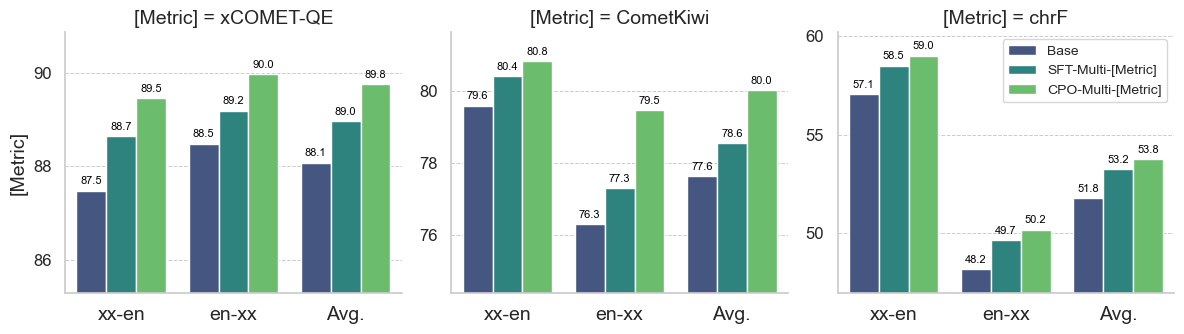

In [775]:
plt.figure(figsize=(4 * len(plot_info), 3.5))

for i, info in enumerate(plot_info):
    systems = info["systems"]
    metric = info["metric"]
    df = pd.DataFrame()
    df["lang_pair"] = ["xx-en"] * len(systems) + ["en-xx"] * len(systems) + ["Avg."] * len(systems)
    df["system"] = systems * 3
    df[metric] = None

    for sys in systems:
        df.loc[
            (df.lang_pair == "xx-en") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "en-xx") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "Avg.") & (df.system == sys), metric
        ] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

    plt.subplot(1, len(plot_info), i+1)
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", 3)
    barplot = sns.barplot(x='lang_pair', y=metric, hue='system', data=df, palette=palette)

    for p in barplot.patches:        
        height = p.get_height()
        if height > 0:
            barplot.annotate(format(height, '.1f'),
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            xytext=(0, 3),
                            textcoords='offset points',
                            fontsize=8, color='black')

    barplot.set_xlabel('')
    barplot.set_ylabel(info["ylabel"], fontsize=14)
    barplot.set_yticks(info["yticks"])
    barplot.set_ylim(df[metric].min() * 0.975, df[metric].max() * info["ylim_sup"])
    barplot.tick_params(axis='x', labelsize=14)
    barplot.tick_params(axis='y', labelsize=12) 
    barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)
    plt.title(f'[Metric] = {metric}', fontsize=14)
    plt.legend([],[], frameon=False)

handles, _ = barplot.get_legend_handles_labels()
labels = ['Base', 'SFT-Multi-[Metric]', 'CPO-Multi-[Metric]']
plt.legend(handles=handles, labels=labels, loc='upper right', fontsize=10)
plt.subplots_adjust(wspace=-1)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/{file_name}.pdf")
plt.show()

## Figure 2

In [776]:
plot_info = [
    {
        "systems": ["Base", "CPO-Multi-xCOMET-QE-Choose-Base"], 
        "metric": "xCOMET-QE",
        "yticks": np.linspace(0, 100, 51),
        "ylim_sup": 1.015,
    },
]
file_name = "XXX"

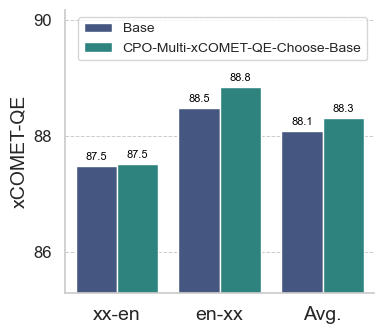

In [777]:
plt.figure(figsize=(4 * len(plot_info), 3.5))

for i, info in enumerate(plot_info):
    systems = info["systems"]
    metric = info["metric"]
    df = pd.DataFrame()
    df["lang_pair"] = ["xx-en"] * len(systems) + ["en-xx"] * len(systems) + ["Avg."] * len(systems)
    df["system"] = systems * 3
    df[metric] = None

    for sys in systems:
        df.loc[
            (df.lang_pair == "xx-en") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "en-xx") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "Avg.") & (df.system == sys), metric
        ] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

    plt.subplot(1, len(plot_info), i+1)
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", 3)
    barplot = sns.barplot(x='lang_pair', y=metric, hue='system', data=df, palette=palette)

    for p in barplot.patches:        
        height = p.get_height()
        if height > 0:
            barplot.annotate(format(height, '.1f'),
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            xytext=(0, 3),
                            textcoords='offset points',
                            fontsize=8, color='black')

    barplot.set_xlabel('')
    barplot.set_ylabel(metric, fontsize=14)
    barplot.set_yticks(info["yticks"])
    barplot.set_ylim(df[metric].min() * 0.975, df[metric].max() * info["ylim_sup"])
    barplot.tick_params(axis='x', labelsize=14)
    barplot.tick_params(axis='y', labelsize=12) 
    barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)

plt.legend(fontsize=10)
plt.subplots_adjust(wspace=-1)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/{file_name}.pdf")
plt.show()

## Figure 3

In [778]:
plot_info = [
    {
        "systems": ["Base", "SFT-Multi-xCOMET-QE", "CPO-Multi-xCOMET-QE"],
        "metric": "chrF",
        "yticks": np.linspace(0, 100, 21),
        "ylim_sup": 1.02,
    },
]
file_name = "XXX"

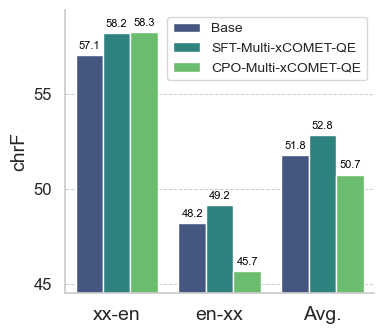

In [779]:
plt.figure(figsize=(4 * len(plot_info), 3.5))

for i, info in enumerate(plot_info):
    systems = info["systems"]
    metric = info["metric"]
    df = pd.DataFrame()
    df["lang_pair"] = ["xx-en"] * len(systems) + ["en-xx"] * len(systems) + ["Avg."] * len(systems)
    df["system"] = systems * 3
    df[metric] = None

    for sys in systems:
        df.loc[
            (df.lang_pair == "xx-en") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "en-xx") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "Avg.") & (df.system == sys), metric
        ] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

    plt.subplot(1, len(plot_info), i+1)
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", 3)
    barplot = sns.barplot(x='lang_pair', y=metric, hue='system', data=df, palette=palette)

    for p in barplot.patches:        
        height = p.get_height()
        if height > 0:
            barplot.annotate(format(height, '.1f'),
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            xytext=(0, 3),
                            textcoords='offset points',
                            fontsize=8, color='black')

    barplot.set_xlabel('')
    barplot.set_ylabel(metric, fontsize=14)
    barplot.set_yticks(info["yticks"])
    barplot.set_ylim(df[metric].min() * 0.975, df[metric].max() * info["ylim_sup"])
    barplot.tick_params(axis='x', labelsize=14)
    barplot.tick_params(axis='y', labelsize=12) 
    barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)

plt.legend(fontsize=10)
plt.subplots_adjust(wspace=-1)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/{file_name}.pdf")
plt.show()

## Figure 4

In [780]:
plot_info = [
    {
        "systems": ["Base", "CPO-Multi-xCOMET-QE", "CPO-Mono-xCOMET-QE"],
        "metric": "xCOMET-QE",
        "yticks": np.linspace(0, 100, 51),
        "ylim_sup": 1.005,
    },
    {
        "systems": ["Base", "SFT-Multi-xCOMET-QE", "CPO-Multi-xCOMET-QE"],
        "metric": "chrF",
        "yticks": np.linspace(0, 100, 21),
        "ylim_sup": 1.02,
    },
]
file_name = "XXX"

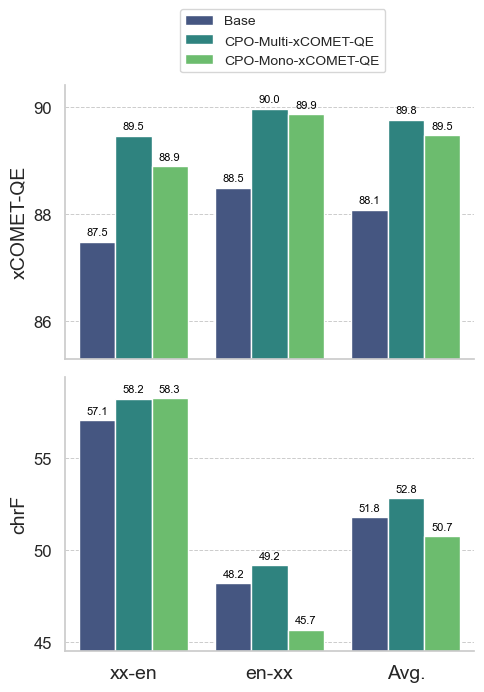

In [781]:
plt.figure(figsize=(5, 3.5 * len(plot_info)))

for i, info in enumerate(plot_info):
    systems = info["systems"]
    metric = info["metric"]
    df = pd.DataFrame()
    df["lang_pair"] = ["xx-en"] * len(systems) + ["en-xx"] * len(systems) + ["Avg."] * len(systems)
    df["system"] = systems * 3
    df[metric] = None

    for sys in systems:
        df.loc[
            (df.lang_pair == "xx-en") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "en-xx") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "Avg.") & (df.system == sys), metric
        ] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

    plt.subplot(len(plot_info), 1, i+1)
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", 3)
    barplot = sns.barplot(x='lang_pair', y=metric, hue='system', data=df, palette=palette)

    for p in barplot.patches:        
        height = p.get_height()
        if height > 0:
            barplot.annotate(format(height, '.1f'),
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            xytext=(0, 3),
                            textcoords='offset points',
                            fontsize=8, color='black')
    
    barplot.set_xlabel('')
    
    if i == 0:
        barplot.set_xticks([])
        plt.legend(fontsize=10, bbox_to_anchor=(0.8,1.3))
    else:
        plt.legend([],[], frameon=False)
    barplot.set_ylabel(metric, fontsize=14)
    barplot.set_yticks(info["yticks"])
    barplot.set_ylim(df[metric].min() * 0.975, df[metric].max() * info["ylim_sup"])
    barplot.tick_params(axis='x', labelsize=14)
    barplot.tick_params(axis='y', labelsize=12) 
    barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)

plt.subplots_adjust(wspace=-1)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/{file_name}.pdf")
plt.show()

## Figure 5

In [782]:
plot_info = {
    "systems": [
        "CPO-Mono-xCOMET-QE-Choose-Low-Reject-Low",
        "CPO-Mono-xCOMET-QE-Choose-Low-Reject-Mid",
        "CPO-Mono-xCOMET-QE-Choose-Low-Reject-High",
        "CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Low",
        "CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Mid",
        "CPO-Mono-xCOMET-QE-Choose-Mid-Reject-High",
        "CPO-Mono-xCOMET-QE-Choose-High-Reject-Low",
        "CPO-Mono-xCOMET-QE-Choose-High-Reject-Mid",
        "CPO-Mono-xCOMET-QE-Choose-High-Reject-High",
    ],
    "metric": "xCOMET-QE",
}

In [783]:
df = pd.DataFrame()
for sys in plot_info["systems"]:
    pref_data_name = f"ALMA-Preference-{sys[sys.find('-')+1:]}"
    pref_df = load_dataset(f"hgissbkh/{pref_data_name}")["train"].to_pandas()
    rej_metric = pref_df[f"rejected_{metrics_dict[plot_info['metric']]}"].mean()
    chos_metric = pref_df[f"chosen_{metrics_dict[plot_info['metric']]}"].mean()
    df.loc[chos_metric, rej_metric] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[plot_info['metric']]}"].mean()











100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


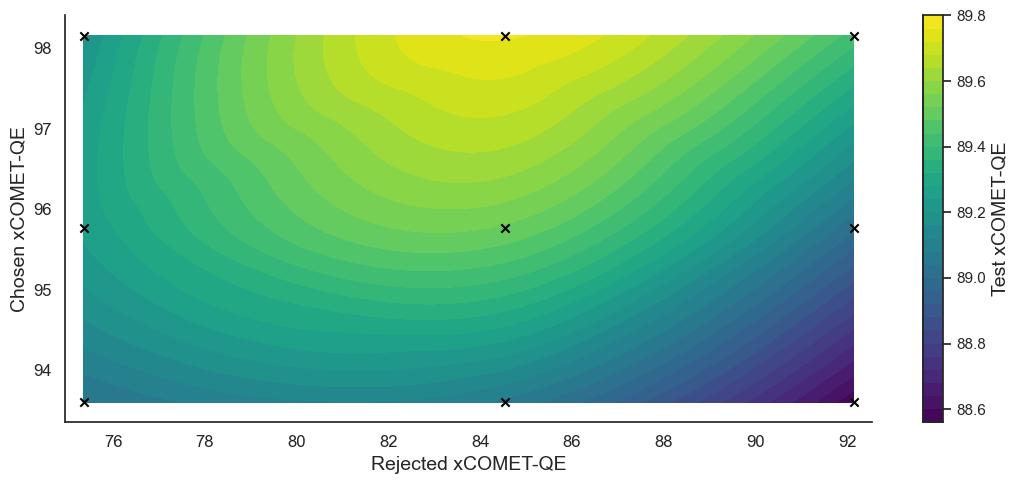

In [784]:
# Collect data
df = pd.DataFrame()
for sys in tqdm(plot_info["systems"]):
    pref_data_name = f"ALMA-Preference-{sys[sys.find('-')+1:]}"
    pref_df = load_dataset(f"hgissbkh/{pref_data_name}")["train"].to_pandas()
    rej_metric = pref_df[f"rejected_{metrics_dict[plot_info['metric']]}"].mean()
    chos_metric = pref_df[f"chosen_{metrics_dict[plot_info['metric']]}"].mean()
    df.loc[chos_metric, rej_metric] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[plot_info['metric']]}"].mean()

# Interpolate data
x1 = np.array(list(df.columns))
x2 = np.array(list(df.index))
f = df.values
x1_grid, x2_grid = np.meshgrid(x1, x2)
points = np.array([x1_grid.flatten(), x2_grid.flatten()]).T
values = f.flatten()
x1_new = np.linspace(x1.min(), x1.max(), 100)
x2_new = np.linspace(x2.min(), x2.max(), 100)
x1_new_grid, x2_new_grid = np.meshgrid(x1_new, x2_new)
f_new = griddata(points, values, (x1_new_grid, x2_new_grid), method='cubic')

# Make plot
plt.figure(figsize=(11, 5))
sns.set(style="white")
contour = plt.contourf(x1_new_grid, x2_new_grid, f_new, levels=30, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_ticks([88.6, 88.8, 89, 89.2, 89.4, 89.6, 89.8])
cbar.set_label(f"Test {plot_info['metric']}", fontsize=14)
for chos in x2:
    for rej in x1:        
        plt.scatter(rej, chos, color="black", marker="x")
plt.xlabel(f"Rejected {plot_info['metric']}", fontsize=14)
plt.ylabel(f"Chosen {plot_info['metric']}", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(df.columns.min() - 0.4, df.columns.max() + 0.4)
plt.ylim(df.index.min() - 0.25, df.index.max() + 0.25)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/qual_study.pdf", bbox_inches='tight')
plt.show()

## Figure 6

In [785]:
plot_info = [
    {
        "systems": ["Base", "CPO-Multi-xCOMET-QE", "CPO-Mono-xCOMET-QE-Optimized"],
        "metric": "xCOMET-QE",
        "yticks": np.linspace(0, 100, 51),
        "ylim_sup": 1.03,
    },
]
file_name = "XXX"

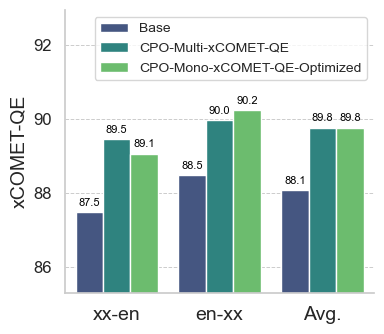

In [787]:
plt.figure(figsize=(4 * len(plot_info), 3.5))

for i, info in enumerate(plot_info):
    systems = info["systems"]
    metric = info["metric"]
    df = pd.DataFrame()
    df["lang_pair"] = ["xx-en"] * len(systems) + ["en-xx"] * len(systems) + ["Avg."] * len(systems)
    df["system"] = systems * 3
    df[metric] = None

    for sys in systems:
        df.loc[
            (df.lang_pair == "xx-en") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "en-xx") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "Avg.") & (df.system == sys), metric
        ] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

    plt.subplot(1, len(plot_info), i+1)
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", 3)
    barplot = sns.barplot(x='lang_pair', y=metric, hue='system', data=df, palette=palette)

    for p in barplot.patches:        
        height = p.get_height()
        if height > 0:
            barplot.annotate(format(height, '.1f'),
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            xytext=(0, 3),
                            textcoords='offset points',
                            fontsize=8, color='black')

    barplot.set_xlabel('')
    barplot.set_ylabel(metric, fontsize=14)
    barplot.set_yticks(info["yticks"])
    barplot.set_ylim(df[metric].min() * 0.975, df[metric].max() * info["ylim_sup"])
    barplot.tick_params(axis='x', labelsize=14)
    barplot.tick_params(axis='y', labelsize=12) 
    barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)

plt.legend(fontsize=10)
plt.subplots_adjust(wspace=-1)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/{file_name}.pdf")
plt.show()

## Table 1

In [788]:
table_info = {
    "systems": [
        "SFT-Multi-xCOMET-QE",
        "SFT-Multi-CometKiwi",
        "SFT-Multi-chrF",
        "CPO-Multi-xCOMET-QE",
        "CPO-Multi-xCOMET-QE-Choose-Base",
        "CPO-Multi-CometKiwi",
        "CPO-Multi-chrF",
        "CPO-Mono-xCOMET-QE",
        "CPO-Mono-xCOMET-QE-Optimized",
    ],
    "lang_pairs": ["xx-en", "en-xx"],
    "neural_metrics": ["xCOMET-QE", "CometKiwi"],
    "lexical_metrics": ["chrF"]
}

In [789]:
# Initialize df
index = ["Base"] \
    + ["SFT-based methods", "Multi-system"] + [sys for sys in table_info["systems"] if "SFT" in sys] \
    + ["CPO-based methods", "Multi-system"] + [sys for sys in table_info["systems"] if "CPO" in sys and "Multi" in sys] \
    + ["Mono-system"] + [sys for sys in table_info["systems"] if "CPO" in sys and "Mono" in sys]
columns = []
for lp in table_info["lang_pairs"]:
    for metric in table_info["neural_metrics"]:
        columns.append((lp, "Neural", metric))
    columns.append((lp, "", ""))
    for metric in table_info["lexical_metrics"]:
        columns.append((lp, "Lexical", metric))
    columns.append(("", "", ""))
df = pd.DataFrame(index=index, columns=pd.MultiIndex.from_tuples(columns[:-1]), data="")

# Collect data
for sys in ["Base"] + table_info["systems"]:
    for lp, typ, metric in df.columns: 
        if lp != "" and typ != "" and metric != "":
            if lp not in ["xx-en", "en-xx", "Avg."]:
                df.loc[sys, (lp, typ, metric)] = eval_df.loc[eval_df.lp == lp, f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean() 
            elif lp == "xx-en":
                df.loc[sys, (lp, typ, metric)] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
            elif lp == "en-xx":
                df.loc[sys, (lp, typ, metric)] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
            elif lp == "Avg.":
                df.loc[sys, (lp, typ, metric)] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

# Print df
df

xx-en                            \
                                    Neural                 Lexical     
                                 xCOMET-QE  CometKiwi         chrF     
Base                             87.479198  79.601284    57.067595     
SFT-based methods                                                      
Multi-system                                                           
SFT-Multi-xCOMET-QE              88.652329  80.237267    58.222576     
SFT-Multi-CometKiwi              88.751841  80.409709    58.417609     
SFT-Multi-chrF                   88.673908  80.236189    58.496088     
CPO-based methods                                                      
Multi-system                                                           
CPO-Multi-xCOMET-QE              89.462906  80.674853     58.25983     
CPO-Multi-xCOMET-QE-Choose-Base  87.508515  79.744063    57.107414     
CPO-Multi-CometKiwi              89.283552  80.826009    58.657902     
CPO-Multi-chrF                   88.680809  80.336847    59.004607     
Mono-system                                                            
CPO-Mono-xCOMET-QE               88.892119   80.52016     57.99236     
CPO-Mono-xCOMET-QE-Optimized     89.059853  80.709148    58.076395     

                                     en-xx                          
                                    Neural                 Lexical  
                                 xCOMET-QE  CometKiwi         chrF  
Base                             88.486331  76.316359     48.18455  
SFT-based methods                                                   
Multi-system                                                        
SFT-Multi-xCOMET-QE              89.192741  77.076256    49.160143  
SFT-Multi-CometKiwi              89.261332  77.309698    49.255994  
SFT-Multi-chrF                   88.814854  76.239034    49.667643  
CPO-based methods                                                   
Multi-system                                                        
CPO-Multi-xCOMET-QE              89.969298  79.497494    45.656784  
CPO-Multi-xCOMET-QE-Choose-Base  88.842469  76.704653    47.767266  
CPO-Multi-CometKiwi              89.236149  79.486421    45.944748  
CPO-Multi-chrF                   87.579464  74.851743    50.188567  
Mono-system                                                         
CPO-Mono-xCOMET-QE               89.866701  78.792984    47.602912  
CPO-Mono-xCOMET-QE-Optimized     90.241843  79.527413    47.547252

In [493]:
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{llllllllll}
\toprule
 & \multicolumn{4}{r}{xx-en} &  & \multicolumn{4}{r}{en-xx} \\
 & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical \\
 & xCOMET-QE & CometKiwi &  & chrF &  & xCOMET-QE & CometKiwi &  & chrF \\
\midrule
Base & 87.48 & 79.60 &  & 57.07 &  & 88.49 & 76.32 &  & 48.18 \\
SFT-based methods &  &  &  &  &  &  &  &  &  \\
Multi-system &  &  &  &  &  &  &  &  &  \\
SFT-Multi-xCOMET-QE & 88.65 & 80.24 &  & 58.22 &  & 89.19 & 77.08 &  & 49.16 \\
SFT-Multi-CometKiwi & 88.75 & 80.41 &  & 58.42 &  & 89.26 & 77.31 &  & 49.26 \\
SFT-Multi-chrF & 88.67 & 80.24 &  & 58.50 &  & 88.81 & 76.24 &  & 49.67 \\
CPO-based methods &  &  &  &  &  &  &  &  &  \\
Multi-system &  &  &  &  &  &  &  &  &  \\
CPO-Multi-xCOMET-QE & 89.46 & 80.67 &  & 58.26 &  & 89.97 & 79.50 &  & 45.66 \\
CPO-Multi-xCOMET-QE-Choose-Base & 87.51 & 79.74 &  & 57.11 &  & 88.84 & 76.70 &  & 47.77 \\
CPO-Multi-CometKiwi & 89.28 & 80.83 &  & 58.66 &  & 89.24 & 79.49 &  & 

## Table 2

In [790]:
table_info = {
    "datasets": [
        "ALMA-Preference-Multi",
        "ALMA-Preference-Multi-xCOMET-QE",
        "ALMA-Preference-Mono-xCOMET-QE"
    ],
    "lang_pairs": ["xx-en", "en-xx", "Avg."],
    "metrics": ["xCOMET-QE", "chrF"],
}

In [791]:
# Initialize df
index = []
for dataset in table_info["datasets"]:
    if dataset == "ALMA-Preference-Multi":
        index += [(dataset, "Base"), (dataset, "GPT-4"), (dataset, "Reference")]
    else:
        index += [(dataset, "Rejected"), (dataset, "Chosen")]
columns = []
for lp in table_info["lang_pairs"]:
    for metric in table_info["metrics"]:
        columns.append((lp, metric))
    columns.append(("", ""))
df = pd.DataFrame(
    index=pd.MultiIndex.from_tuples(index),
    columns=pd.MultiIndex.from_tuples(columns)[:-1],
    data=""
)

# Collect data
for ds in table_info["datasets"]:
    pref_df = load_dataset(f"hgissbkh/{ds}")["train"].to_pandas()
    for sys in df.loc[ds].index:
        for lp, metric in df.columns:
            if lp != "" and metric != "":
                if lp not in ["xx-en", "en-xx", "Avg."]:
                    df.loc[(ds, sys), (lp, metric)] = pref_df.loc[pref_df.lp == lp, f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean() 
                elif lp == "xx-en":
                    df.loc[(ds, sys), (lp, metric)] = pref_df.loc[pref_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
                elif lp == "en-xx":
                    df.loc[(ds, sys), (lp, metric)] = pref_df.loc[pref_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
                elif lp == "Avg.":
                    df.loc[(ds, sys), (lp, metric)] = pref_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

# Print df
df

xx-en                   en-xx  \
                                           xCOMET-QE       chrF    xCOMET-QE   
ALMA-Preference-Multi           Base       92.845293  64.044192    93.316279   
                                GPT-4      94.832154   64.26949    94.341582   
                                Reference  89.013022      100.0    94.533511   
ALMA-Preference-Multi-xCOMET-QE Rejected   85.962967  86.305511    89.665384   
                                Chosen     96.878686  73.620715    97.588709   
ALMA-Preference-Mono-xCOMET-QE  Rejected   88.344408  61.876993    87.285764   
                                Chosen     97.012426  63.337664    97.558384   

                                                             Avg.             
                                                chrF    xCOMET-QE       chrF  
ALMA-Preference-Multi           Base       52.870784    93.086337  58.325796  
                                GPT-4      57.734561    94.581086  60.925004  
                                Reference      100.0    91.838332      100.0  
ALMA-Preference-Multi-xCOMET-QE Rejected    71.02259    87.857813  78.483924  
                                Chosen     78.167907    97.242066  75.947905  
ALMA-Preference-Mono-xCOMET-QE  Rejected   49.795963    87.802609  55.694089  
                                Chosen     51.297781     97.29184  57.175819

In [558]:
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{llllllllll}
\toprule
 &  & \multicolumn{2}{r}{xx-en} &  & \multicolumn{2}{r}{en-xx} &  & \multicolumn{2}{r}{Avg.} \\
 &  & xCOMET-QE & chrF &  & xCOMET-QE & chrF &  & xCOMET-QE & chrF \\
\midrule
\multirow[t]{3}{*}{ALMA-Preference-Multi} & Base & 92.85 & 64.04 &  & 93.32 & 52.87 &  & 93.09 & 58.33 \\
 & GPT-4 & 94.83 & 64.27 &  & 94.34 & 57.73 &  & 94.58 & 60.93 \\
 & Reference & 89.01 & 100.00 &  & 94.53 & 100.00 &  & 91.84 & 100.00 \\
\cline{1-10}
\multirow[t]{2}{*}{ALMA-Preference-Multi-xCOMET-QE} & Rejected & 85.96 & 86.31 &  & 89.67 & 71.02 &  & 87.86 & 78.48 \\
 & Chosen & 96.88 & 73.62 &  & 97.59 & 78.17 &  & 97.24 & 75.95 \\
\cline{1-10}
\multirow[t]{2}{*}{ALMA-Preference-Mono-xCOMET-QE} & Rejected & 88.34 & 61.88 &  & 87.29 & 49.80 &  & 87.80 & 55.69 \\
 & Chosen & 97.01 & 63.34 &  & 97.56 & 51.30 &  & 97.29 & 57.18 \\
\cline{1-10}
\bottomrule
\end{tabular}



# Appendix

## Figure 7

In [792]:
plot_info = {
    "hf_data_path": "hgissbkh/ALMA-Preference-Multi",
    "colors": {
        "cs": "blue",
        "de": "orange",
        "en": "green",
        "is": "red",
        "ru": "purple",
        "zh": "brown"
    },
    "save_path": "/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/test_langs.pdf"
}

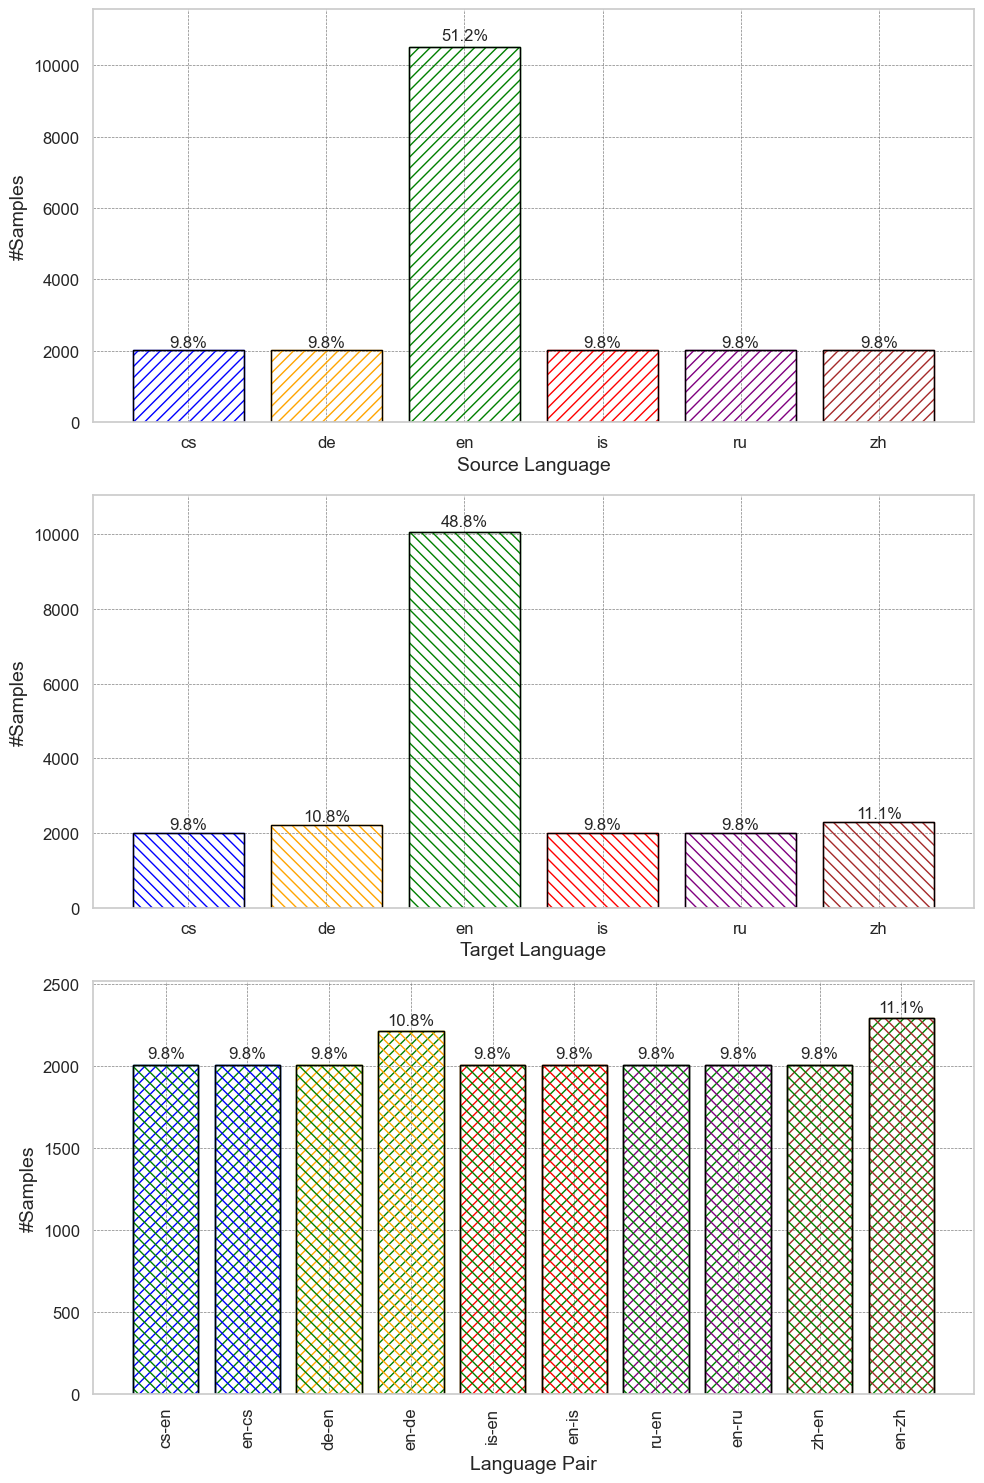

In [793]:
# Get data
ds = load_dataset(plot_info["hf_data_path"])["train"].to_pandas()
count_lp = ds.groupby("lp").count().iloc[:,0][["cs-en", "en-cs", "de-en", "en-de", "is-en", "en-is", "ru-en", "en-ru", "zh-en", "en-zh"]]
count_src_lang = ds.groupby("src_lang").count().iloc[:,0]
count_tgt_lang = ds.groupby("tgt_lang").count().iloc[:,0]

# Make plot
plt.figure(figsize=(10, 15))

# Source Language Frequency
ax = plt.subplot(3, 1, 1)
for i, src_lang in enumerate(count_src_lang.index):
    ax.bar(src_lang, count_src_lang[src_lang], edgecolor=plot_info["colors"][src_lang], hatch='/'*3, facecolor='none')
    ax.bar(src_lang, count_src_lang[src_lang], edgecolor='black', facecolor='none')
    ax.text(i, count_src_lang[src_lang] + 0.01 * count_src_lang[src_lang], f'{count_src_lang[src_lang]/count_src_lang.sum()*100:.1f}%', ha='center', va='bottom')
ax.set_xlabel("Source Language", fontsize=14)
ax.set_ylabel("#Samples", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim(0, 1.1*count_src_lang.max())
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Target Language Frequency
ax = plt.subplot(3, 1, 2)
for i, tgt_lang in enumerate(count_tgt_lang.index):
    ax.bar(tgt_lang, count_tgt_lang[tgt_lang], edgecolor=plot_info["colors"][tgt_lang], hatch='\\'*3, facecolor='none')
    ax.bar(tgt_lang, count_tgt_lang[tgt_lang], edgecolor='black', facecolor='none')
    ax.text(i, count_tgt_lang[tgt_lang] + 0.01 * count_tgt_lang[tgt_lang], f'{count_tgt_lang[tgt_lang]/count_tgt_lang.sum()*100:.1f}%', ha='center', va='bottom')
ax.set_xlabel("Target Language", fontsize=14)
ax.set_ylabel("#Samples", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim(0, 1.1*count_tgt_lang.max())
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Language Pair Frequency
ax = plt.subplot(3, 1, 3)
for i, lp in enumerate(count_lp.index):
    src_lang, tgt_lang = lp.split("-")
    ax.bar(lp, count_lp[lp], edgecolor=plot_info["colors"][src_lang], hatch='/'*3, facecolor='none')
    ax.bar(lp, count_lp[lp], edgecolor=plot_info["colors"][tgt_lang], hatch='\\'*3, facecolor='none')
    ax.bar(lp, count_lp[lp], edgecolor='black', facecolor='none')
    ax.text(i, count_lp[lp] + 0.01 * count_lp[lp], f'{count_lp[lp]/count_lp.sum()*100:.1f}%', ha='center', va='bottom')
ax.set_xlabel("Language Pair", fontsize=14)
ax.set_ylabel("#Samples", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim(0, 1.1*count_lp.max())
ax.set_xticklabels(count_lp.index, rotation=90)
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
# plt.savefig(plot_info["save_path"])
plt.show()

## Figure 8

In [794]:
plot_info = {
    "hf_data_path": "hgissbkh/WMT22-23-Test",
    "colors": {
        "cs": "blue",
        "de": "orange",
        "en": "green",
        "is": "red",
        "ru": "purple",
        "zh": "brown"
    },
    "save_path": "/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/test_langs.pdf"
}

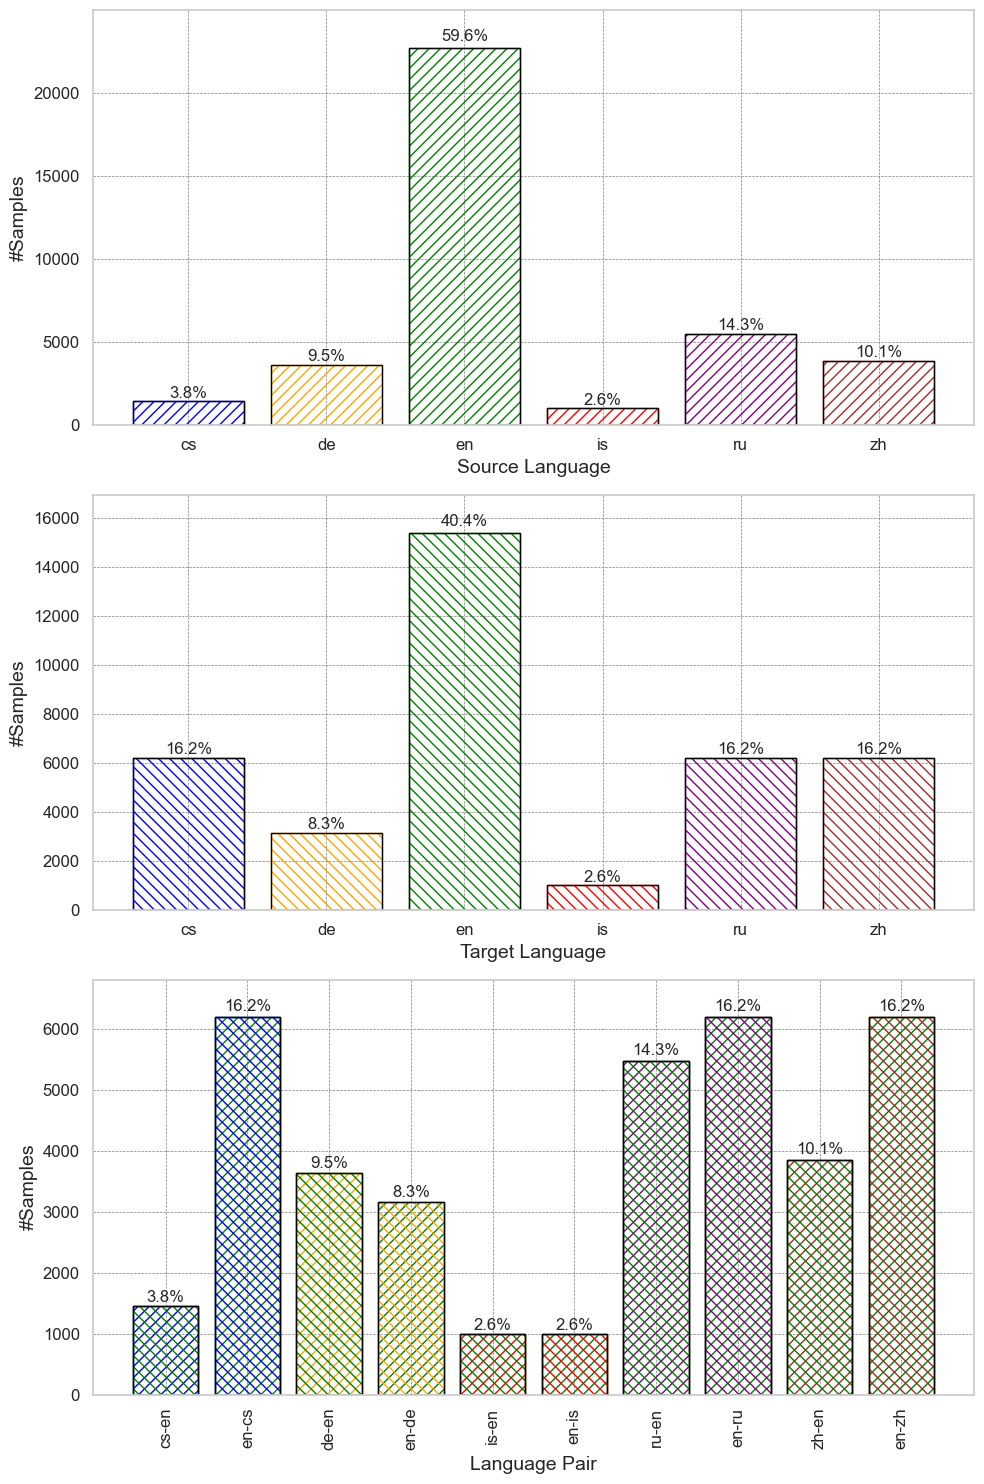

In [795]:
# Get data
ds = load_dataset(plot_info["hf_data_path"])["train"].to_pandas()
count_lp = ds.groupby("lp").count().iloc[:,0][["cs-en", "en-cs", "de-en", "en-de", "is-en", "en-is", "ru-en", "en-ru", "zh-en", "en-zh"]]
count_src_lang = ds.groupby("src_lang").count().iloc[:,0]
count_tgt_lang = ds.groupby("tgt_lang").count().iloc[:,0]

# Make plot
plt.figure(figsize=(10, 15))

# Source Language Frequency
ax = plt.subplot(3, 1, 1)
for i, src_lang in enumerate(count_src_lang.index):
    ax.bar(src_lang, count_src_lang[src_lang], edgecolor=plot_info["colors"][src_lang], hatch='/'*3, facecolor='none')
    ax.bar(src_lang, count_src_lang[src_lang], edgecolor='black', facecolor='none')
    ax.text(i, count_src_lang[src_lang] + 0.01 * count_src_lang[src_lang], f'{count_src_lang[src_lang]/count_src_lang.sum()*100:.1f}%', ha='center', va='bottom')
ax.set_xlabel("Source Language", fontsize=14)
ax.set_ylabel("#Samples", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim(0, 1.1*count_src_lang.max())
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Target Language Frequency
ax = plt.subplot(3, 1, 2)
for i, tgt_lang in enumerate(count_tgt_lang.index):
    ax.bar(tgt_lang, count_tgt_lang[tgt_lang], edgecolor=plot_info["colors"][tgt_lang], hatch='\\'*3, facecolor='none')
    ax.bar(tgt_lang, count_tgt_lang[tgt_lang], edgecolor='black', facecolor='none')
    ax.text(i, count_tgt_lang[tgt_lang] + 0.01 * count_tgt_lang[tgt_lang], f'{count_tgt_lang[tgt_lang]/count_tgt_lang.sum()*100:.1f}%', ha='center', va='bottom')
ax.set_xlabel("Target Language", fontsize=14)
ax.set_ylabel("#Samples", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim(0, 1.1*count_tgt_lang.max())
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Language Pair Frequency
ax = plt.subplot(3, 1, 3)
for i, lp in enumerate(count_lp.index):
    src_lang, tgt_lang = lp.split("-")
    ax.bar(lp, count_lp[lp], edgecolor=plot_info["colors"][src_lang], hatch='/'*3, facecolor='none')
    ax.bar(lp, count_lp[lp], edgecolor=plot_info["colors"][tgt_lang], hatch='\\'*3, facecolor='none')
    ax.bar(lp, count_lp[lp], edgecolor='black', facecolor='none')
    ax.text(i, count_lp[lp] + 0.01 * count_lp[lp], f'{count_lp[lp]/count_lp.sum()*100:.1f}%', ha='center', va='bottom')
ax.set_xlabel("Language Pair", fontsize=14)
ax.set_ylabel("#Samples", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim(0, 1.1*count_lp.max())
ax.set_xticklabels(count_lp.index, rotation=90)
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
# plt.savefig(plot_info["save_path"])
plt.show()

## Tables 3 & 4

In [796]:
table_info = {
    "systems": [
        "SFT-Multi-xCOMET-QE",
        "SFT-Multi-CometKiwi",
        "SFT-Multi-chrF",
        "CPO-Multi-xCOMET-QE",
        "CPO-Multi-xCOMET-QE-Choose-Base",
        "CPO-Multi-CometKiwi",
        "CPO-Multi-chrF",
        "CPO-Mono-xCOMET-QE",
        "CPO-Mono-xCOMET-QE-Optimized",
    ],
    "lang_pairs": [
        "cs-en", "en-cs", 
        "de-en", "en-de", 
        "is-en", "en-is",
        "ru-en", "en-ru", 
        "zh-en", "en-zh",
        "xx-en", "en-xx",
        "Avg."
    ],
    "neural_metrics": ["xCOMET-QE", "CometKiwi", "Comet22", "MetricX"],
    "lexical_metrics": ["chrF", "BLEU"]
}

In [797]:
# Initialize df
index = ["Base"] \
    + ["SFT-based methods", "Multi-system"] + [sys for sys in table_info["systems"] if "SFT" in sys] \
    + ["CPO-based methods", "Multi-system"] + [sys for sys in table_info["systems"] if "CPO" in sys and "Multi" in sys] \
    + ["Mono-system"] + [sys for sys in table_info["systems"] if "CPO" in sys and "Mono" in sys]
columns = []
for lp in table_info["lang_pairs"]:
    for metric in table_info["neural_metrics"]:
        columns.append((lp, "Neural", metric))
    columns.append((lp, "", ""))
    for metric in table_info["lexical_metrics"]:
        columns.append((lp, "Lexical", metric))
    columns.append(("", "", ""))
df = pd.DataFrame(index=index, columns=pd.MultiIndex.from_tuples(columns[:-1]), data="")

# Collect data
for sys in ["Base"] + table_info["systems"]:
    for lp, typ, metric in df.columns: 
        if lp != "" and typ != "" and metric != "":
            if lp not in ["xx-en", "en-xx", "Avg."]:
                df.loc[sys, (lp, typ, metric)] = eval_df.loc[eval_df.lp == lp, f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean() 
            elif lp == "xx-en":
                df.loc[sys, (lp, typ, metric)] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
            elif lp == "en-xx":
                df.loc[sys, (lp, typ, metric)] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
            elif lp == "Avg.":
                df.loc[sys, (lp, typ, metric)] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

# Print df
df

cs-en                                    \
                                    Neural                                     
                                 xCOMET-QE  CometKiwi    Comet22   MetricX     
Base                             83.424095  82.568772  86.233286  2.004189     
SFT-based methods                                                              
Multi-system                                                                   
SFT-Multi-xCOMET-QE              86.175248  83.174234  86.610912  1.980319     
SFT-Multi-CometKiwi              86.165793  83.313566   86.65284  1.967714     
SFT-Multi-chrF                   86.150225  82.908158  86.647823  1.987711     
CPO-based methods                                                              
Multi-system                                                                   
CPO-Multi-xCOMET-QE              87.399289  83.579098  86.710559  1.944257     
CPO-Multi-xCOMET-QE-Choose-Base  83.996117  82.765244  86.347645  2.047263     
CPO-Multi-CometKiwi               86.74449  83.464809  86.690157  1.947157     
CPO-Multi-chrF                   86.649337  82.985624  86.703859  1.983363     
Mono-system                                                                    
CPO-Mono-xCOMET-QE               85.992698  83.655266  86.647618   1.92503     
CPO-Mono-xCOMET-QE-Optimized     86.513787  83.840926  86.653701    1.9029     

                                                             en-cs             \
                                   Lexical                  Neural              
                                      chrF       BLEU    xCOMET-QE  CometKiwi   
Base                             65.813957  41.250999    87.530053  76.165534   
SFT-based methods                                                               
Multi-system                                                                    
SFT-Multi-xCOMET-QE              67.355127  42.813589    88.559847  77.023805   
SFT-Multi-CometKiwi              67.500735  43.077834    88.660536  77.387777   
SFT-Multi-chrF                    67.66598  43.225325    88.571898  76.203118   
CPO-based methods                                                               
Multi-system                                                                    
CPO-Multi-xCOMET-QE              67.524681   42.53534    88.001883  79.363049   
CPO-Multi-xCOMET-QE-Choose-Base  66.088342  41.946849    88.201508  76.939313   
CPO-Multi-CometKiwi              67.672425  42.419159    87.198005  79.522741   
CPO-Multi-chrF                   68.328994  43.185534    87.054526  74.120668   
Mono-system                                                                     
CPO-Mono-xCOMET-QE               67.101803  42.086639    89.079765  79.056105   
CPO-Mono-xCOMET-QE-Optimized     67.076692  41.731261    89.428537  79.640022   

                                 ...      en-xx                    Avg.  \
                                 ...    Lexical                  Neural   
                                 ...       chrF       BLEU    xCOMET-QE   
Base                             ...   48.18455  28.963828    88.079439   
SFT-based methods                ...                                      
Multi-system                     ...                                      
SFT-Multi-xCOMET-QE              ...  49.160143  29.808334    88.974409   
SFT-Multi-CometKiwi              ...  49.255994     29.836    89.055493   
SFT-Multi-chrF                   ...  49.667643  30.309889    88.757911   
CPO-based methods                ...                                      
Multi-system                     ...                                      
CPO-Multi-xCOMET-QE              ...  45.656784  25.345836     89.76471   
CPO-Multi-xCOMET-QE-Choose-Base  ...  47.767266  28.719273    88.303537   
CPO-Multi-CometKiwi              ...  45.944748  25.137082    89.255301   
CPO-Multi-chrF                   ...  50.188567   29.61096    88.024419   
Mono-system 

In [754]:
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll}
\toprule
 & \multicolumn{7}{r}{cs-en} &  & \multicolumn{7}{r}{en-cs} &  & \multicolumn{7}{r}{de-en} &  & \multicolumn{7}{r}{en-de} &  & \multicolumn{7}{r}{is-en} &  & \multicolumn{7}{r}{en-is} &  & \multicolumn{7}{r}{ru-en} &  & \multicolumn{7}{r}{en-ru} &  & \multicolumn{7}{r}{zh-en} &  & \multicolumn{7}{r}{en-zh} &  & \multicolumn{7}{r}{xx-en} &  & \multicolumn{7}{r}{en-xx} &  & \multicolumn{7}{r}{Avg.} \\
 & \multicolumn{4}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{4}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{4}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{4}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{4}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{4}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{4}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multico

## Table 5 & 6

In [798]:
table_info = {
    "datasets": [
        "ALMA-Preference-Multi",
        "ALMA-Preference-Multi-xCOMET-QE",
        "ALMA-Preference-Multi-CometKiwi",
        "ALMA-Preference-Multi-chrF",
        "ALMA-Preference-Mono-xCOMET-QE",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Reject-Low",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Reject-Mid",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Reject-High",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Reject-Low",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Reject-Mid",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Reject-High",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reject-Low",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reject-Mid",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reject-High",
    ],
    "lang_pairs": [
        "cs-en", "en-cs", 
        "de-en", "en-de", 
        "is-en", "en-is",
        "ru-en", "en-ru", 
        "zh-en", "en-zh",
        "xx-en", "en-xx",
        "Avg."
    ],
    "neural_metrics": ["xCOMET-QE", "CometKiwi"],
    "lexical_metrics": ["chrF"]
}

In [799]:
# Initialize df
index = []
for dataset in table_info["datasets"]:
    if dataset == "ALMA-Preference-Multi":
        index += [(dataset, "Base"), (dataset, "GPT-4"), (dataset, "Reference")]
    else:
        index += [(dataset, "Rejected"), (dataset, "Chosen")]
columns = []
for lp in table_info["lang_pairs"]:
    for metric in table_info["neural_metrics"]:
        columns.append((lp, "Neural", metric))
    columns.append((lp, "", ""))
    for metric in table_info["lexical_metrics"]:
        columns.append((lp, "Lexical", metric))
    columns.append(("", "", ""))
df = pd.DataFrame(
    index=pd.MultiIndex.from_tuples(index),
    columns=pd.MultiIndex.from_tuples(columns)[:-1],
    data=""
)

# Collect data
for ds in table_info["datasets"]:
    pref_df = load_dataset(f"hgissbkh/{ds}")["train"].to_pandas()
    for sys in df.loc[ds].index:
        for lp, typ, metric in df.columns:
            if lp != "" and metric != "":
                if lp not in ["xx-en", "en-xx", "Avg."]:
                    df.loc[(ds, sys), (lp, typ, metric)] = pref_df.loc[pref_df.lp == lp, f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean() 
                elif lp == "xx-en":
                    df.loc[(ds, sys), (lp, typ, metric)] = pref_df.loc[pref_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
                elif lp == "en-xx":
                    df.loc[(ds, sys), (lp, typ, metric)] = pref_df.loc[pref_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
                elif lp == "Avg.":
                    df.loc[(ds, sys), (lp, typ, metric)] = pref_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

# Print df
df

cs-en  \
                                                                 Neural   
                                                              xCOMET-QE   
ALMA-Preference-Multi                              Base       92.740435   
                                                   GPT-4        95.5118   
                                                   Reference  88.638721   
ALMA-Preference-Multi-xCOMET-QE                    Rejected   85.068657   
                                                   Chosen     97.506058   
ALMA-Preference-Multi-CometKiwi                    Rejected   87.200038   
                                                   Chosen     95.541616   
ALMA-Preference-Multi-chrF                         Rejected   93.454476   
                                                   Chosen      94.79737   
ALMA-Preference-Mono-xCOMET-QE                     Rejected   87.383005   
                                                   Chosen     97.400872   
ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Rejec... Rejected   75.173404   
                                                   Chosen     93.326544   
ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Rejec... Rejected   83.974335   
                                                   Chosen     93.326544   
ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Rejec... Rejected   91.511792   
                                                   Chosen     93.326544   
ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Rejec... Rejected   75.173404   
                                                   Chosen     95.700411   
ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Rejec... Rejected   83.974335   
                                                   Chosen     95.700411   
ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Rejec... Rejected   91.511792   
                                                   Chosen     95.700411   
ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reje... Rejected   75.173404   
                                                   Chosen     98.026623   
ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reje... Rejected   83.974335   
                                                   Chosen     98.026623   
ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reje... Rejected   91.511792   
                                                   Chosen     98.026623   

                                                                           \
                                                                            
                                                              CometKiwi     
ALMA-Preference-Multi                              Base       90.771946     
                                                   GPT-4      91.365442     
                                                   Reference  87.287018     
ALMA-Preference-Multi-xCOMET-QE                    Rejected   86.854467     
                                                   Chosen     91.769459     
ALMA-Preference-Multi-CometKiwi                    Rejected    85.68512     
                                                   Chosen     92.761285     
ALMA-Preference-Multi-chrF                         Rejected   90.712691     
                                                   Chosen     91.424892     
ALMA-Preference-Mono-xCOMET-QE                     Rejected   88.878222     
                                                   Chosen     91.819721     
ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Rejec... Rejected   85.415484     
                                                   Chosen     90.666026     
ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Rejec... Rejected   88.120888     
                                                   Chosen     90.666026     
ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Rejec... Rejected   89.920796     
                                                   Chosen     90.666026     
ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Rejec... Rejected   85.415484     
                                                

In [757]:
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll}
\toprule
 &  & \multicolumn{4}{r}{cs-en} &  & \multicolumn{4}{r}{en-cs} &  & \multicolumn{4}{r}{de-en} &  & \multicolumn{4}{r}{en-de} &  & \multicolumn{4}{r}{is-en} &  & \multicolumn{4}{r}{en-is} &  & \multicolumn{4}{r}{ru-en} &  & \multicolumn{4}{r}{en-ru} &  & \multicolumn{4}{r}{zh-en} &  & \multicolumn{4}{r}{en-zh} &  & \multicolumn{4}{r}{xx-en} &  & \multicolumn{4}{r}{en-xx} &  & \multicolumn{4}{r}{Avg.} \\
 &  & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical &  & 